# Inference

- Run inference on the test dataset.
- Mainly for testing your model is doing ok visually.

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import matplotlib.pyplot as plt
import tqdm
import torch
import numpy as np

import sys; sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Nucleus")
data_dir = root_dir / "Data"
model_dir = root_dir / "Models"

# Import the configuration associated with this dataset and network.
config = maskflow.config.load_config(root_dir / "config.yaml")

In [5]:
def split_list(input_list, list_sizes):
    """
    Example:
    > print(split_list(list(range(10)), [3, 2, 5]))
    > [[0, 1, 2], [3, 4], [2, 3, 4, 5, 6]]
    """
    assert sum(list_sizes) == len(input_list)
    new_list = []
    start_index = 0
    for i in list_sizes:
        new_list.append(input_list[start_index:start_index+i])
        start_index = i
    return new_list
    
split_list(list(range(10)), [3, 2, 5])

[[0, 1, 2], [3, 4], [2, 3, 4, 5, 6]]

In [9]:
# Select the model
model_name = 'maskrccn-nucleus-2.0.0'
model_path = model_dir / model_name

# Set some configurations
config['MODEL']['DEVICE'] = "cuda"
config['DATALOADER']['NUM_WORKERS'] = 4
config['TEST']['IMS_PER_BATCH'] = 2
config['SOLVER']['IMS_PER_BATCH'] = 2
batch_to_load = 2

# Build the model
model = maskflow.inference.build_model(config, model_path)

# Load some data
data_loader = maskflow.dataset.get_data_loader(config, data_dir, is_train=False)
data = [datum for _, datum in zip(range(batch_to_load), data_loader)]

# Retrieve category's names
categories = data_loader.dataset.coco.cats

# Run inference
predictions = []
images = []
ground_truth = []
for batch_image, batch_target, batch_idx in data:
    batch_image = batch_image.to(config['MODEL']['DEVICE'])
    with torch.no_grad():
        prediction = model(batch_image)
        prediction = [o.to('cpu') for o in prediction]
        predictions.extend(prediction)
        images.extend([im for im in batch_image.tensors])
        ground_truth.extend(batch_target)
        
images = np.array([o.to('cpu').numpy() for o in images])
len(images)

2018-11-07 13:33:11,484:INFO:maskrcnn_benchmark.utils.checkpoint: Loading checkpoint from /home/hadim/.data/Neural_Network/Maskflow/Nucleus/Models/maskrccn-nucleus-2.0.0/model_0002000.pth
2018-11-07 13:33:11,693:WARNING:maskrcnn_benchmark.data.build: When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory. If this happens, you can reduce SOLVER.IMS_PER_BATCH (for training) or TEST.IMS_PER_BATCH (for inference). For training, you must also adjust the learning rate and schedule length according to the linear scaling rule. See for example: https://github.com/facebookresearch/Detectron/blob/master/configs/getting_started/tutorial_1gpu_e2e_faster_rcnn_R-50-FPN.yaml#L14


loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


4

51
tensor([0.9988, 0.9972, 0.9972, 0.9970, 0.9967, 0.9966, 0.9965, 0.9962, 0.9956,
        0.9940, 0.9930, 0.9912, 0.9912, 0.9906, 0.9899, 0.9888, 0.9881, 0.9853,
        0.9844, 0.9841, 0.9840, 0.9803, 0.9793, 0.9792, 0.9715, 0.9672, 0.9641,
        0.9632, 0.9612, 0.9551, 0.9530, 0.9504, 0.9502, 0.9437, 0.9393, 0.9378,
        0.9241, 0.9205, 0.9160, 0.9019, 0.9010, 0.8956, 0.8906, 0.8579, 0.8505,
        0.8271, 0.8263, 0.8249, 0.8207, 0.7147, 0.7023])


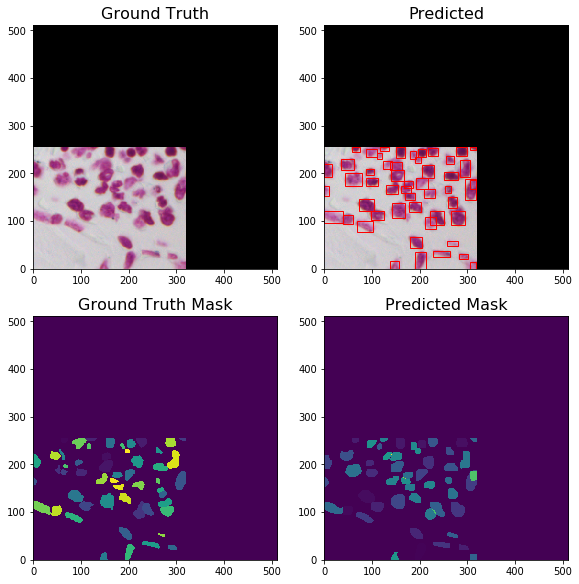

In [7]:
# Show prediction
idx = 0
image = images[idx]
prediction = predictions[idx]
gt = ground_truth[idx]

prediction = maskflow.inference.select_top_predictions(prediction, confidence_threshold=0.7)

print(prediction.bbox.shape[0])
print(prediction.get_field('scores'))

_ = maskflow.viz.display_prediction_and_gt(image, prediction, gt,
                                           class_names=config['CLASS_NAMES'],
                                           pixel_mean=config['INPUT']['PIXEL_MEAN'],
                                           pixel_std=config['INPUT']['PIXEL_STD'])